In [1]:
# Import libraries
from pathlib import Path
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit.Chem import MolFromSmiles, rdmolops, Draw
import torch
from rdkit import Chem
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool, GATConv, TransformerConv
from sklearn.metrics import root_mean_squared_error
sns.set_style()

# Setup GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: 'NoneType' object has no attribute 'origin'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [2]:
# Read data
dataset = pd.read_csv(Path("../data/dataset_processed.csv"))

The dataset contains mixture of molecules, which are a problem since they will result in disconnected graphs.

Mixtures: 798


[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors
[17:16:41] WARNING: not removing hydrogen atom without neighbors


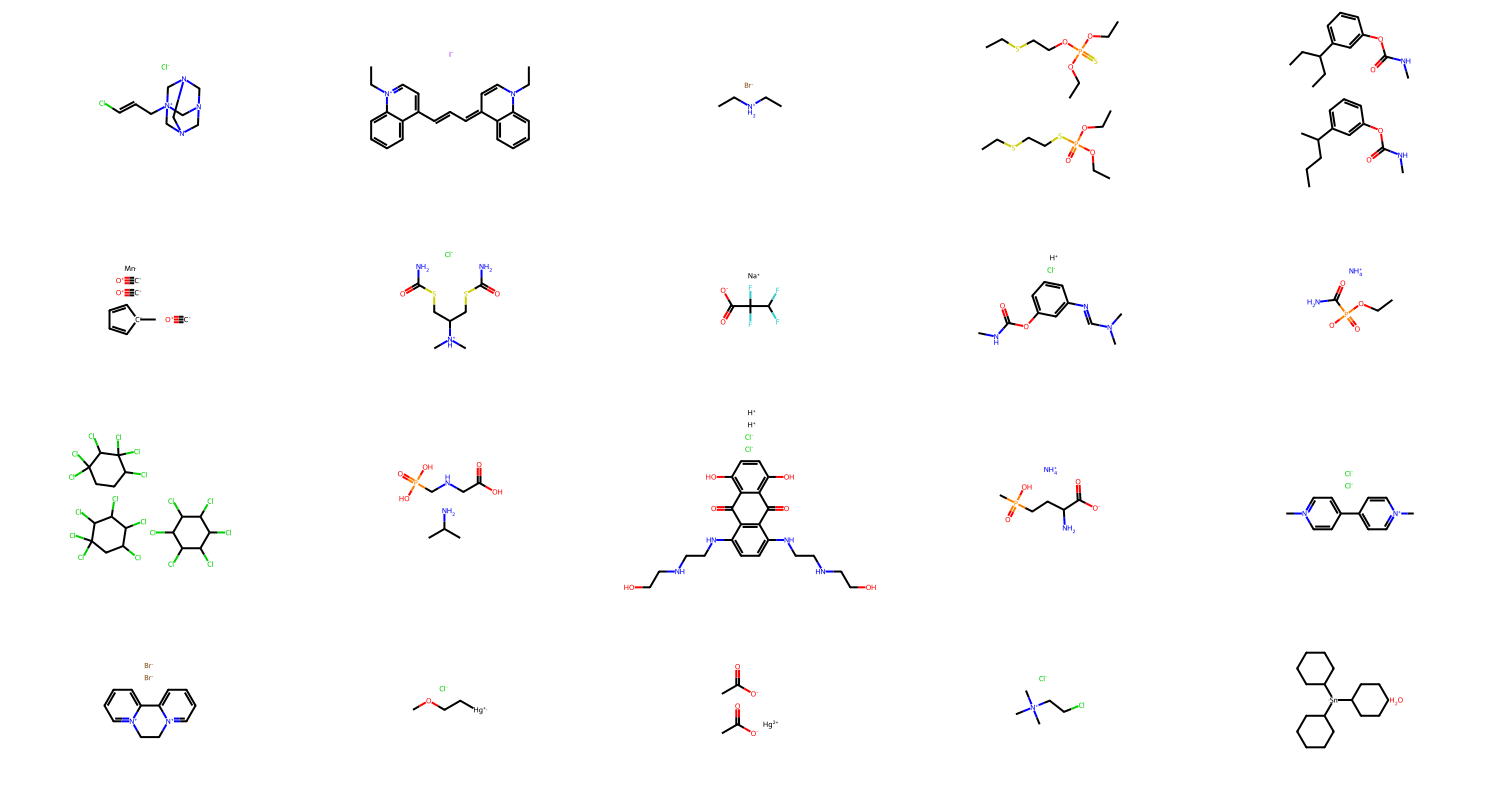

In [3]:
mixtures = dataset.loc[dataset["SMILES"].str.contains(r"\."), ]
print(f"Mixtures: {len(mixtures)}")
# Convert SMILES strings to molecule objects
molecules = []
legends = []
for index, row in mixtures.tail(20).iterrows():
    mol = MolFromSmiles(row['SMILES'])
    molecules.append(mol)

Draw.MolsToGridImage(molecules, molsPerRow=5, legends=legends, subImgSize=(300,200))

Some compounds are salts with their respective anion or cation, but other compounds are real mixtures of different compounds. Since they are only 798, they are simply dropped.

In [4]:
# Drop mixtures
dataset = dataset.drop(mixtures.index, axis=0)
# Split the data into features and labels
X = dataset.drop(columns=["Solubility"])
y = dataset["Solubility"]

# First split: 60% training, 40% remaining (validation + test)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split: 50% of the remaining data for validation and 50% for testing
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (5214, 39)
X_test shape: (1739, 39)
X_val shape: (1738, 39)
y_train shape: (5214,)
y_test shape: (1739,)
y_val shape: (1738,)


# Create molecular graphs

In [5]:
# Define functions to create node and edge features
def get_atomic_vectors(atom: Chem.Atom) -> list[int]:
    """
    Generate a one-hot encoded vector representing the atomic symbol of a given atom.

    This function maps specific atomic symbols to their corresponding one-hot encoded vectors. 
    If the atomic symbol is not in the predefined dictionary, it returns a default encoding vector of zeros.

    Args:
        atom (Chem.Atom): An RDKit atom object from which the atomic symbol will be retrieved.

    Returns:
        List[int]: A list of integers representing the one-hot encoded vector of the atomic symbol lenght 9.
    """
    # Define hash table
    atomic_hashes = {
        "C": 0*[0] + [1] + 8*[0],
        "N": 1*[0] + [1] + 7*[0],
        "O": 2*[0] + [1] + 6*[0],
        "F": 3*[0] + [1] + 5*[0],
        "P": 4*[0] + [1] + 4*[0],
        "S": 5*[0] + [1] + 3*[0],
        "Cl": 6*[0] + [1] + 2*[0],
        "Br": 7*[0] + [1] + 1*[0],
        "I": 8*[0] + [1] + 0*[0]}
    
    # Default encoding for any other element not in hash table is array of zeros
    default_encoding = 9*[0]
    atomic_symbol = atom.GetSymbol()
    encoding = atomic_hashes.get(atomic_symbol, default_encoding)
            
    return encoding

def get_hybridization_vector(atom: Chem.Atom) -> list[int]:
    """
    Generate a vector representing the hybridization state of a given atom.

    The hybridization types considered are SP, SP2, and SP3. 
    Other types are represented by a default vector.

    Args:
        atom (Chem.Atom): An RDKit atom object from which the hybridization state will be retrieved.

    Returns:
        List[int]: A list of integers representing the hybridization state of the atom.
    """
    
    hybridization_type = atom.GetHybridization()
    if hybridization_type == Chem.HybridizationType.SP:
        return [1,0]
    elif hybridization_type == Chem.HybridizationType.SP2:
        return [0,1]
    elif hybridization_type == Chem.HybridizationType.SP3:
        return [1,1]
    else:
        return [0,0]

def atom_features(atom: Chem.Atom) -> list[int]:
    """
    Generate a feature vector for a given atom.

    The feature vector includes atomic symbol encoding, degree, formal charge, 
    hybridization state, and aromaticity.

    Args:
        atom (Chem.Atom): An RDKit atom object from which features will be extracted.

    Returns:
        List[int]: A list of integers representing the feature vector of the atom.
    """
    # Get one-hot encoded element vector
    element_vector = get_atomic_vectors(atom)
    # Get degree for given atom
    degree_vector = [atom.GetDegree()]
    # Get formal charge for given atom
    charge_vector = [atom.GetFormalCharge()]
    # Get implicit valence as vector
    valence_vector = [atom.GetImplicitValence()]
    # Get one-hot encoded vector for hybridization state of given atom
    hybridization_vector = get_hybridization_vector(atom)
    # Get boolean vector if atom is in an aromatic ring system
    aromatic_vector = [int(atom.GetIsAromatic())]
    # Get integer values for atom mass
    mass_vector = [atom.GetMass()]
    
    # Combine vectors
    feature_vector = element_vector + degree_vector + charge_vector + valence_vector + hybridization_vector + aromatic_vector + mass_vector
    
    return feature_vector 

def get_bond_type_vector(bond: Chem.Bond) -> list[int]:
    """
    Returns a one-hot encoded vector representing the bond type of the given RDKit Bond object.

    Parameters:
    bond (Chem.Bond): An RDKit Bond object.

    Returns:
    list[int]: A list of integers representing the bond type:
               [1, 0, 0] for single bonds,
               [0, 1, 0] for double bonds,
               [0, 0, 1] for triple bonds,
               [1, 1, 0] for aromatic bonds,
               [0, 0, 0] for any other bond type.
    """
    
    bond_type = bond.GetBondType()
    if bond_type == Chem.rdchem.BondType.SINGLE:
        return [1,0,0]
    elif bond_type == Chem.rdchem.BondType.DOUBLE:
        return [0,1,0]
    elif bond_type == Chem.rdchem.BondType.TRIPLE:
        return [0,0,1]
    elif bond_type == Chem.rdchem.BondType.AROMATIC:
        return [1,1,0]
    else:
        return [0,0,0]
    
def bond_features(bond: Chem.Bond) -> list[float]:
    """
    Generate a feature vector for a given bond.

    The feature vector includes bond type as 1.0, 1.5 and 2.0 for single, aromatic and double bound, 
    conjugation, and ring status.

    Args:
        bond (Chem.Bond): An RDKit bond object from which features will be extracted.

    Returns:
        List[float]: A list of floats representing the feature vector of the bond.
    """
    # Get bond type vector
    type_vector = get_bond_type_vector(bond)
    # Get conjugation vector
    conjugation_vector = [int(bond.GetIsConjugated())]
    # Get ring vector
    ring_vector = [int(bond.IsInRing())]
    
    # Combine vectors
    bond_vector = type_vector + conjugation_vector + ring_vector
    
    return bond_vector

In [6]:
# Demonstration how one-hot encoding of elements works
for smile in ["C", "N", "O", "F", "P", "S", "Cl", "Br", "I", "B"]:
    mol = MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        print(f"{smile}: {atom_features(atom)}")

C: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 0, 12.011]
N: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 14.007]
O: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 15.999]
F: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 18.998]
P: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 30.974]
S: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 32.067]
Cl: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 35.453]
Br: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 79.904]
I: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 126.904]
B: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 10.812]


In [7]:
def create_graph_dataset(data: pd.DataFrame, labels: pd.DataFrame) -> list[Data]:
    """
    Create a dataset of molecular graphs with node and edge features for machine learning tasks.

    This function processes a DataFrame containing molecular structures represented as SMILES strings 
    and their corresponding labels. 
    It iterates through each row of the DataFrame, converts each SMILES string to an RDKit molecule object, and 
    computes node and edge features for each atom and bond in the molecule. These features are then 
    used to construct a PyTorch Geometric Data object, which includes node features, edge indices 
    derived from the molecule's adjacency matrix, edge features, and the corresponding label (solubility).

    Args:
        data (pd.DataFrame): DataFrame containing SMILES strings under the column "SMILES".
        labels (pd.DataFrame): DataFrame containing labels corresponding to each SMILES structure.

    Returns:
        List[Data]: A list of PyTorch Geometric Data objects, each representing a molecule as a graph 
        with associated features and labels.
    """
    
    dataset = []
    graph_feature_columns = ["MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHDonors", "NumRotatableBonds",
                             "NumValenceElectrons", "NumAromaticRings", "LabuteASA", "BertzCT", "C", "Cl", "Na",
                             "Br", "F", "K", "O"]
    
    for index, row in data.iterrows():
        try:
            # Extract smiles and corresponding solubility
            smiles = row["SMILES"]
            solubility = labels.loc[index, ]
            solubility = torch.tensor(solubility, dtype=torch.float32)
            
            # Create molecule object
            mol = MolFromSmiles(smiles)
            if mol is None:
                raise ValueError(f"Invalid SMILES string: {smiles}")
            
            # Calculate node, edge and graph-level features
            node_features = [atom_features(atom) for atom in mol.GetAtoms()]
            edge_features = [bond_features(atom) for atom in mol.GetBonds()]
            graph_features = list(row.loc[graph_feature_columns].values)
            
            # Get adjacency matrix
            adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
            
            # Get the edge indices from the adjacency matrix
            edge_indices = np.array(np.nonzero(adj_matrix))
            
            # Create PyTorch Geometric data object
            data = Data(
                x=torch.tensor(node_features, dtype=torch.float), 
                edge_index=torch.tensor(edge_indices, dtype=torch.long),
                edge_attr=torch.tensor(edge_features, dtype=torch.float),
                graph_attr=torch.tensor(graph_features, dtype=torch.float),
                y=solubility
                )
            
            dataset.append(data)
        
        except Exception as e:
            print(f"Error processing index {index}: {e}")
    
    return dataset

In [8]:
# Create datasets
train_dataset = create_graph_dataset(X_train, y_train)
val_dataset = create_graph_dataset(X_val, y_val)
test_dataset = create_graph_dataset(X_test, y_test)

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

-4.1122


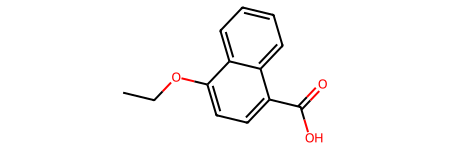

In [9]:
# Check how graph is build
print(y_train.iloc[0])
MolFromSmiles(X_train.iloc[0]["SMILES"])

In [10]:
# Investigating the graph
print("Dataset sample: ", train_dataset[0])
print("Sample nodes: ", train_dataset[0].num_nodes)
print("Sample edges: ", train_dataset[0].num_edges)
print()
print("Sample node features: ", train_dataset[0].x)
print()
print("Sample edge index: ", train_dataset[0].edge_index.t())
print()
print("Sample edge attributes: ", train_dataset[0].edge_attr)
print()
print("Sample graph attributes: ", train_dataset[0].graph_attr)

Dataset sample:  Data(x=[16, 16], edge_index=[2, 34], edge_attr=[17, 5], y=-4.112199783325195, graph_attr=[17])
Sample nodes:  16
Sample edges:  34

Sample node features:  tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  3.0000,  1.0000,  1.0000,  0.0000, 12.0110],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  2.0000,  0.0000,  2.0000,  1.0000,  1.0000,  0.0000, 12.0110],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  2.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000, 15.9990],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  3.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000, 12.0110],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  2.0000,  0.0000,  1.0000,  0.0000,  1.0000,  1.0000, 12.0110],
        [ 1.0

# Setup training and testing loops

In [11]:
def train_loop(model: torch.nn.Module, name: str) -> None:
    """
    Train a given model using Mean Squared Error loss and Adam optimizer.
    
    Args:
        model (torch.nn.Module): The neural network model to be trained.
        name (str): The name used to save the best model state.

    Returns:
        None
    """
    
    # Setup loss and optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Send model to GPU
    model = model.to(device)

    # Setup training loop
    def train(train_loader: torch.utils.data.DataLoader) -> float:
        """
        Train the model for one epoch.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader for the training data.

        Returns:
            float: The average training loss over the epoch.
        """
        
        # Set model to training mode
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            predictions = model(batch)
            
            # Calculating the loss and gradients
            loss = loss_fn(predictions.squeeze(), batch.y)
            loss.backward()
            
            # Update using the gradients
            optimizer.step()
            total_loss += loss.item()
        
        return total_loss / len(train_loader)

    # Setup validation loop
    def validate(val_loader: torch.utils.data.DataLoader) -> float:
        """
        Validate the model for one epoch.

        Args:
            val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.

        Returns:
            float: The average validation loss over the epoch.
        """
        
        # Set model to validation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                predictions = model(batch)
                
                # Calculating the loss
                loss = loss_fn(predictions.squeeze(), batch.y)
                val_loss += loss.item()
        
        # Return average loss over batch
        return val_loss / len(val_loader)

    # Perform training
    print("Starting training")
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 100
    patience_counter = 0

    for epoch in range(5000):
        train_loss = train(train_loader)
        val_loss = validate(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            print(f"Best val_los: {best_val_loss:.3f}")
            torch.save( best_model_state, Path(f"../models/{name}.pth"))
            break
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss {train_loss:.4f} | Validation Loss {val_loss:.4f}")

In [12]:
def evaluate_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, name:str = "") -> float:
    """
    Evaluate a given model on a dataset and calculate the Root Mean Squared Error (RMSE).
    
    Args:
        model (torch.nn.Module): The neural network model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation data.
        name (str, optional): An optional name for the model evaluation, used in the print statement. Defaults to "".

    Returns:
        None
    """
    # Send model to GPU
    model.to(device)
    # Set model to evaluation mode
    model.eval()

    # List to store predictions
    all_predictions = []

    # Make predictions
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            predictions = model(batch)
            all_predictions.append(predictions.cpu())

    # Concatenate all predictions
    all_predictions = torch.cat(all_predictions, dim=0)
    all_predictions = all_predictions.view(-1)

    # Calculate RMSE on test set
    rmse_score = root_mean_squared_error(y_pred=all_predictions, y_true=labels.values)
    print(f"RMSE {name}: {rmse_score:.3f}")
    
    return rmse_score

# Build and train graph convolutional network

In [13]:
EMBEDDING_SIZE = 64

# Build network
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.conv1 = GCNConv(train_dataset[0].x.shape[1], EMBEDDING_SIZE)
        self.conv2 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.conv3 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        
        # Dense layer
        self.dense = Linear(EMBEDDING_SIZE, EMBEDDING_SIZE // 2)

        # Output layer
        self.output = Linear(EMBEDDING_SIZE // 2, 1)

    def forward(self, data):
        # Unpack data
        x, edge_index, batch = data.x, data.edge_index, data.batch
 
        # Conv Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Conv Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Conv Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        # Pooling layer
        x = global_max_pool(x, batch)
        # Dense layer
        x = self.dense(x)
        x = F.relu(x)
        # Output dense neuron
        output = self.output(x)

        return output

conv_model = GCN()
print(conv_model)

GCN(
  (conv1): GCNConv(16, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dense): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [14]:
# Train model
train_loop(model=conv_model, name="conv_model")

Starting training


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss 6.3141 | Validation Loss 5.4439
Epoch 10 | Train Loss 2.3754 | Validation Loss 2.1246
Epoch 20 | Train Loss 2.0675 | Validation Loss 1.9504
Epoch 30 | Train Loss 1.8018 | Validation Loss 1.8189
Epoch 40 | Train Loss 1.6733 | Validation Loss 1.6248
Epoch 50 | Train Loss 1.5736 | Validation Loss 1.6483
Epoch 60 | Train Loss 1.4890 | Validation Loss 1.5166
Epoch 70 | Train Loss 1.4084 | Validation Loss 1.4995
Epoch 80 | Train Loss 1.3228 | Validation Loss 1.4174
Epoch 90 | Train Loss 1.3105 | Validation Loss 1.3554
Epoch 100 | Train Loss 1.1915 | Validation Loss 1.3529
Epoch 110 | Train Loss 1.1428 | Validation Loss 1.3045
Epoch 120 | Train Loss 1.1206 | Validation Loss 1.2910
Epoch 130 | Train Loss 1.0738 | Validation Loss 1.3170
Epoch 140 | Train Loss 1.0494 | Validation Loss 1.3060
Epoch 150 | Train Loss 1.0037 | Validation Loss 1.2696
Epoch 160 | Train Loss 0.9663 | Validation Loss 1.3148
Epoch 170 | Train Loss 0.9683 | Validation Loss 1.2359
Epoch 180 | Train Los

In [16]:
# Load best model
conv_model = GCN()
conv_model.load_state_dict(torch.load(Path("../models/conv_model.pth")))
# Evaluate model
evaluate_model(model=conv_model, dataloader=val_loader, name="conv_model", labels=y_val)


RMSE conv_model: 1.085


1.085081579455639

# Build and train graph attention network

In [17]:
EMBEDDING_SIZE = 64
HEADS = 4

# Build network
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        # GAT layers
        self.conv1 = GATConv(train_dataset[0].x.shape[1], EMBEDDING_SIZE, heads=HEADS, concat=True)
        self.conv2 = GATConv(EMBEDDING_SIZE * HEADS, EMBEDDING_SIZE, heads=HEADS, concat=True)
        self.conv3 = GATConv(EMBEDDING_SIZE * HEADS, EMBEDDING_SIZE, heads=HEADS, concat=True)
        
        # Dense layer
        self.dense = Linear(EMBEDDING_SIZE * HEADS, EMBEDDING_SIZE // 2)

        # Output layer
        self.output = Linear(EMBEDDING_SIZE // 2, 1)

    def forward(self, data):
        # Unpack data
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Conv Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Conv Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Conv Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        # Pooling layer
        x = global_max_pool(x, batch)
        # Dense layer
        x = self.dense(x)
        x = F.relu(x)
        # Output dense neuron
        output = self.output(x)

        return output

attention_model = GAT()
print(attention_model)

GAT(
  (conv1): GATConv(16, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv3): GATConv(256, 64, heads=4)
  (dense): Linear(in_features=256, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [18]:
# Train model
train_loop(model=attention_model, name="attention_model")

Starting training


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss 5.1471 | Validation Loss 4.1728
Epoch 10 | Train Loss 1.6023 | Validation Loss 1.6876
Epoch 20 | Train Loss 1.2237 | Validation Loss 1.2625
Epoch 30 | Train Loss 0.9930 | Validation Loss 1.2281
Epoch 40 | Train Loss 0.8636 | Validation Loss 1.2319
Epoch 50 | Train Loss 0.6706 | Validation Loss 1.1006
Epoch 60 | Train Loss 0.5313 | Validation Loss 1.1014
Epoch 70 | Train Loss 0.4829 | Validation Loss 1.0968
Epoch 80 | Train Loss 0.3692 | Validation Loss 1.1427
Epoch 90 | Train Loss 0.3258 | Validation Loss 1.1539
Epoch 100 | Train Loss 0.2901 | Validation Loss 1.1314
Epoch 110 | Train Loss 0.2311 | Validation Loss 1.1407
Epoch 120 | Train Loss 0.2182 | Validation Loss 1.1371
Epoch 130 | Train Loss 0.2387 | Validation Loss 1.1274
Epoch 140 | Train Loss 0.2057 | Validation Loss 1.1027
Early stopping at epoch 149
Best val_los: 1.041


In [19]:
# Load best model
attention_model = GAT()
attention_model.load_state_dict(torch.load(Path("../models/attention_model.pth")))
# Evaluate model
evaluate_model(model=attention_model, dataloader=val_loader, name="attenion_model", labels=y_val)

RMSE attenion_model: 1.026


1.0257249481289914

# Transformer

In [20]:
class Transformer(torch.nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        torch.manual_seed(42)

        # TransformerConv layers
        self.conv1 = TransformerConv(train_dataset[0].x.shape[1], EMBEDDING_SIZE, heads=HEADS, concat=True)
        self.conv2 = TransformerConv(EMBEDDING_SIZE * HEADS, EMBEDDING_SIZE, heads=HEADS, concat=True)
        self.conv3 = TransformerConv(EMBEDDING_SIZE * HEADS, EMBEDDING_SIZE, heads=HEADS, concat=True)
        
        # Dense layer
        self.dense = Linear(EMBEDDING_SIZE * HEADS, EMBEDDING_SIZE // 2)

        # Output layer
        self.output = Linear(EMBEDDING_SIZE // 2, 1)

    def forward(self, data):
        # Unpack data
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Conv Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Conv Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Conv Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        # Pooling layer
        x = global_max_pool(x, batch)
        # Dense layer
        x = self.dense(x)
        x = F.relu(x)
        # Output dense neuron
        output = self.output(x)

        return output

transformer = Transformer()
print(transformer)

Transformer(
  (conv1): TransformerConv(16, 64, heads=4)
  (conv2): TransformerConv(256, 64, heads=4)
  (conv3): TransformerConv(256, 64, heads=4)
  (dense): Linear(in_features=256, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [21]:
# Train model
train_loop(model=transformer, name="transformer")

Starting training


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss 4.8077 | Validation Loss 4.4260
Epoch 10 | Train Loss 1.5163 | Validation Loss 1.6938
Epoch 20 | Train Loss 1.1072 | Validation Loss 1.2857
Epoch 30 | Train Loss 0.8562 | Validation Loss 1.1832
Epoch 40 | Train Loss 0.6380 | Validation Loss 1.1699
Epoch 50 | Train Loss 0.5183 | Validation Loss 1.1281
Epoch 60 | Train Loss 0.4180 | Validation Loss 1.1254
Epoch 70 | Train Loss 0.3999 | Validation Loss 1.1776
Epoch 80 | Train Loss 0.3538 | Validation Loss 1.2114
Epoch 90 | Train Loss 0.2796 | Validation Loss 1.2187
Epoch 100 | Train Loss 0.2598 | Validation Loss 1.2765
Epoch 110 | Train Loss 0.2967 | Validation Loss 1.2552
Epoch 120 | Train Loss 0.2471 | Validation Loss 1.2717
Epoch 130 | Train Loss 0.2832 | Validation Loss 1.1896
Epoch 140 | Train Loss 0.1844 | Validation Loss 1.2129
Early stopping at epoch 144
Best val_los: 1.115


In [22]:
# Load best model
transformer = Transformer()
transformer.load_state_dict(torch.load(Path("../models/transformer.pth")))
# Evaluate model
evaluate_model(model=transformer, dataloader=val_loader, name="transformer", labels=y_val)

RMSE transformer: 1.058


1.0582787662472593

# Use 2D descriptors as graph-level features

In [23]:
EMBEDDING_SIZE = 64
GRAPH_FEATURE_SIZE = train_dataset[0].graph_attr.shape[0]

# Build network
class GCN_full(torch.nn.Module):
    def __init__(self):
        super(GCN_full, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.conv1 = GCNConv(train_dataset[0].x.shape[1], EMBEDDING_SIZE)
        self.conv2 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        self.conv3 = GCNConv(EMBEDDING_SIZE, EMBEDDING_SIZE)
        
        # Dense layers
        self.dense1 = Linear(EMBEDDING_SIZE + GRAPH_FEATURE_SIZE, EMBEDDING_SIZE // 2)
        self.dense2 = Linear(EMBEDDING_SIZE // 2, EMBEDDING_SIZE // 2)
        
        # Output layer
        self.output = Linear(EMBEDDING_SIZE // 2, 1)

    def forward(self, data):
        # Unpack data
        x, edge_index, batch, graph_feat = data.x, data.edge_index, data.batch, data.graph_attr
 
        # Conv Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Conv Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Conv Layer 3
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # Pooling layer
        x = global_max_pool(x, batch)
        
        # Incorporate graph-level features
        graph_feat = graph_feat.reshape(-1, GRAPH_FEATURE_SIZE)
        x = torch.cat([x, graph_feat], dim=1)  
        
        # Dense layer1
        x = self.dense1(x)
        x = F.relu(x)
        # Dense layer2
        x = self.dense2(x)
        x = F.relu(x)
        
        # Output dense neuron
        output = self.output(x)

        return output

conv_model_full = GCN_full()
print(conv_model_full)

GCN_full(
  (conv1): GCNConv(16, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dense1): Linear(in_features=81, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [24]:
# Train model
train_loop(model=conv_model_full, name="conv_model_full")

Starting training


/home/manuel/anaconda3/envs/molecule_solubility/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss 4.2079 | Validation Loss 1.8792
Epoch 10 | Train Loss 1.0939 | Validation Loss 1.0478
Epoch 20 | Train Loss 0.9941 | Validation Loss 0.9921
Epoch 30 | Train Loss 0.9225 | Validation Loss 0.9279
Epoch 40 | Train Loss 0.8593 | Validation Loss 0.8539
Epoch 50 | Train Loss 0.7946 | Validation Loss 0.8314
Epoch 60 | Train Loss 0.7587 | Validation Loss 0.8498
Epoch 70 | Train Loss 0.7213 | Validation Loss 0.7808
Epoch 80 | Train Loss 0.7146 | Validation Loss 0.7753
Epoch 90 | Train Loss 0.6483 | Validation Loss 0.7876
Epoch 100 | Train Loss 0.6461 | Validation Loss 0.9230
Epoch 110 | Train Loss 0.6421 | Validation Loss 0.7682
Epoch 120 | Train Loss 0.5838 | Validation Loss 0.7702
Epoch 130 | Train Loss 0.5722 | Validation Loss 0.7627
Epoch 140 | Train Loss 0.5605 | Validation Loss 0.8061
Epoch 150 | Train Loss 0.5388 | Validation Loss 0.7623
Epoch 160 | Train Loss 0.5219 | Validation Loss 0.7480
Epoch 170 | Train Loss 0.4969 | Validation Loss 0.8065
Epoch 180 | Train Los

In [27]:
# Load best model
conv_model_full = GCN_full()
conv_model_full.load_state_dict(torch.load(Path("../models/conv_model_full.pth")))
# Evaluate model
evaluate_model(model=conv_model_full, dataloader=val_loader, name="conv_model_full", labels=y_val)

RMSE conv_model_full: 0.863


0.8630961896936844

# Evaluate models on test set

In [28]:
# Load models
conv_model = GCN()
conv_model.load_state_dict(torch.load(Path("../models/conv_model.pth")))
attention_model = GAT()
attention_model.load_state_dict(torch.load(Path("../models/attention_model.pth")))
transformer = Transformer()
transformer.load_state_dict(torch.load(Path("../models/transformer.pth")))
conv_model_full = GCN_full()
conv_model_full.load_state_dict(torch.load(Path("../models/conv_model_full.pth")))

<All keys matched successfully>

RMSE Graph Convolution: 1.110
RMSE Graph Attention: 1.066
RMSE Transformer: 1.096
RMSE Graph Convolution (+ graph-level features): 0.921


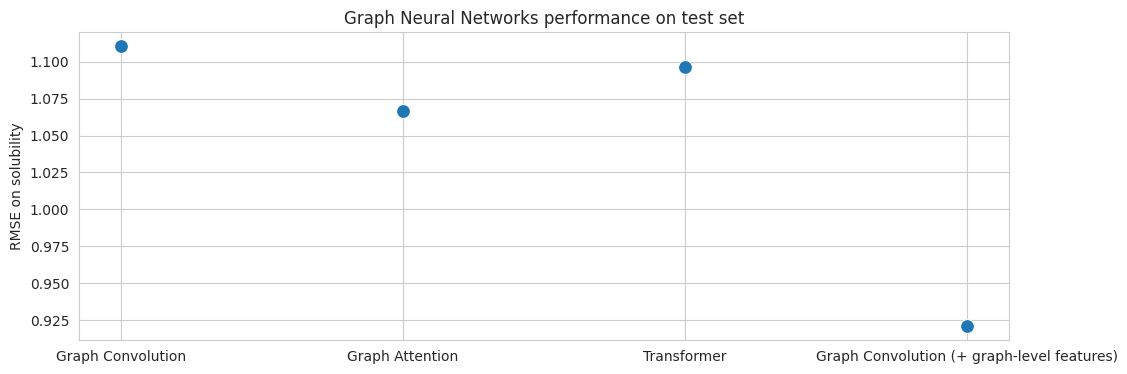

In [29]:
# Compare performances of graph-based models on test set
graph_models = {
    "Graph Convolution": conv_model,
    "Graph Attention": attention_model,
    "Transformer": transformer,
    "Graph Convolution (+ graph-level features)": conv_model_full,
}

model_results = {}
for model_name, model in graph_models.items():
    rmse_score = evaluate_model(model=model, dataloader=test_loader, labels=y_test, name=model_name)
    model_results[model_name] = rmse_score

# Plot results
sns.set_style("whitegrid")
plt.figure(figsize=(12,4))
sns.scatterplot(data=model_results, s=100)
plt.ylabel("RMSE on solubility")
plt.title("Graph Neural Networks performance on test set")
plt.show()

# Error analysis

In [30]:
# Send model to GPU
model.to(device)
# Set model to evaluation mode
model.eval()

# List to store predictions
all_predictions = []

# Make predictions
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        predictions = model(batch)
        all_predictions.append(predictions.cpu())

# Concatenate all predictions
all_predictions = torch.cat(all_predictions, dim=0)
all_predictions = all_predictions.view(-1)

# Create dataframe for error analysis
error_analysis_df = X_test.assign(
    solubility=y_test,
    prediction=all_predictions)
# Add residuals
error_analysis_df = error_analysis_df.assign(
    residual=error_analysis_df["solubility"] - error_analysis_df["prediction"])

error_analysis_df

,ID,Name,InChI,InChIKey,SMILES,SD,Ocurrences,Group,MolWt,MolLogP,...,C,O,Na,Cl,K,Br,F,solubility,prediction,residual
1422,A-2624,"2,3-bis(acetyloxy)propyl dodecanoate",InChI=1S/C19H34O6/c1-4-5-6-7-8-9-10-11-12-13-1...,NBMAHNZMRSQCPG-UHFFFAOYSA-N,CCCCCCCCCCCC(=O)OCC(COC(C)=O)OC(C)=O,0.000000,1,G1,0.715156,0.631818,...,0.911981,1.435086,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-6.378368,-4.963870,-1.414498
3466,B-335,4-chloro-2-nitroaniline,InChI=1S/C6H5ClN2O2/c7-4-1-2-5(8)6(3-4)9(10)11...,PBGKNXWGYQPUJK-UHFFFAOYSA-N,Nc1ccc(Cl)cc1[N+]([O-])=O,0.358348,2,G3,-0.614120,-0.113807,...,-0.818777,-0.286636,-0.161261,0.490596,-0.060251,-0.134458,-0.153927,-2.538000,-2.835503,0.297503
1404,A-2596,"2,5,7,8-tetramethyl-2-(4,8,12-trimethyltridecy...",InChI=1S/C31H52O3/c1-21(2)13-10-14-22(3)15-11-...,ZAKOWWREFLAJOT-CEFNRUSXSA-N,CC(C)CCC[C@@H](C)CCC[C@@H](C)CCC[C@]1(C)CCc2c(...,0.000000,1,G1,1.532290,2.435034,...,2.509605,0.143794,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-5.771545,-7.656179,1.884634
7327,C-1444,"1,5-bis(pivaloyloxymethyl)allopurinol","InChI=1S/C17H24N4O5/c1-16(2,3)14(23)25-9-20-8-...",XEXFVLNTPDXOJB-UHFFFAOYSA-N,CC(C)(C)C(=O)OCN1C=NC2=C(C=N[N]2COC(=O)C(C)(C)...,0.000000,1,G1,0.757536,-0.164505,...,0.645711,1.004656,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-4.260000,-4.066458,-0.193542
7136,C-1018,acronine; acromycine; acronycine,InChI=1S/C20H19NO3/c1-20(2)10-9-13-15(24-20)11...,SMPZPKRDRQOOHT-UHFFFAOYSA-N,COC1=C2C(=O)C3=C(C=CC=C3)N(C)C2=C4C=CC(C)(C)OC...,0.000000,1,G1,0.449886,0.610383,...,1.045117,0.143794,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-5.210000,-5.639695,0.429695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7256,C-1311,allopurin-1-yl-methyl butyrate; 1-(butanoyl...,InChI=1S/C10H12N4O3/c1-2-3-8(15)17-6-14-9-7(4-...,IIVOEPVKDWTLJB-UHFFFAOYSA-N,CCCC(=O)OC[N]1N=CC2=C1N=CNC2=O,0.000000,1,G1,-0.158929,-0.610914,...,-0.286236,0.143794,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-2.830000,-1.979212,-0.850788
3320,B-98,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,JYHCQVWYCGHXGP-BPPSBWQWSA-N,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@...,0.000000,1,G1,1.329835,-0.889929,...,1.311387,2.295948,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-3.284000,-3.038629,-0.245371
1764,A-3209,benzyldimethylamine,"InChI=1S/C9H13N/c1-10(2)8-9-6-4-3-5-7-9/h3-7H,...",XXBDWLFCJWSEKW-UHFFFAOYSA-N,CN(C)Cc1ccccc1,0.088059,2,G3,-0.881263,-0.142787,...,-0.419371,-1.147498,-0.161261,-0.349250,-0.060251,-0.134458,-0.153927,-1.227919,-0.632509,-0.595410
5652,B-3011,"2,2',4,6,6'-pentachlorobiphenyl",InChI=1S/C12H5Cl5/c13-6-4-9(16)12(10(17)5-6)11...,MTCPZNVSDFCBBE-UHFFFAOYSA-N,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl,0.000000,1,G1,0.486074,1.575017,...,-0.019965,-1.147498,-0.161261,3.849981,-0.060251,-0.134458,-0.153927,-7.316000,-7.009444,-0.306556


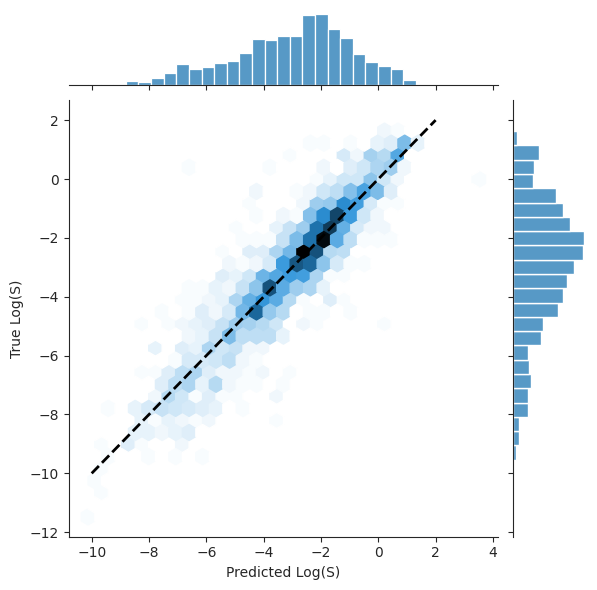

In [31]:
# Create parity plot
sns.set_style("ticks")
sns.jointplot(x=error_analysis_df.loc[:, "prediction"], y=error_analysis_df.loc[:, "solubility"], kind="hex")
x_line = np.linspace(-10, 2, 100)
y_line = x_line
plt.plot(x_line, y_line, color='black', linestyle='--', linewidth=2, label='y = x')
plt.xlabel('Predicted Log(S)')
plt.ylabel('True Log(S)')
plt.show()

In [32]:
# Select overestimated and underestimated entries
top10_underestimated = error_analysis_df.sort_values(by="residual").iloc[:10,].loc[:, ["Name", "SMILES", "solubility", "prediction"]]
top10_overestimated = error_analysis_df.sort_values(by="residual").iloc[-10:,].loc[:, ["Name", "SMILES", "solubility", "prediction"]]

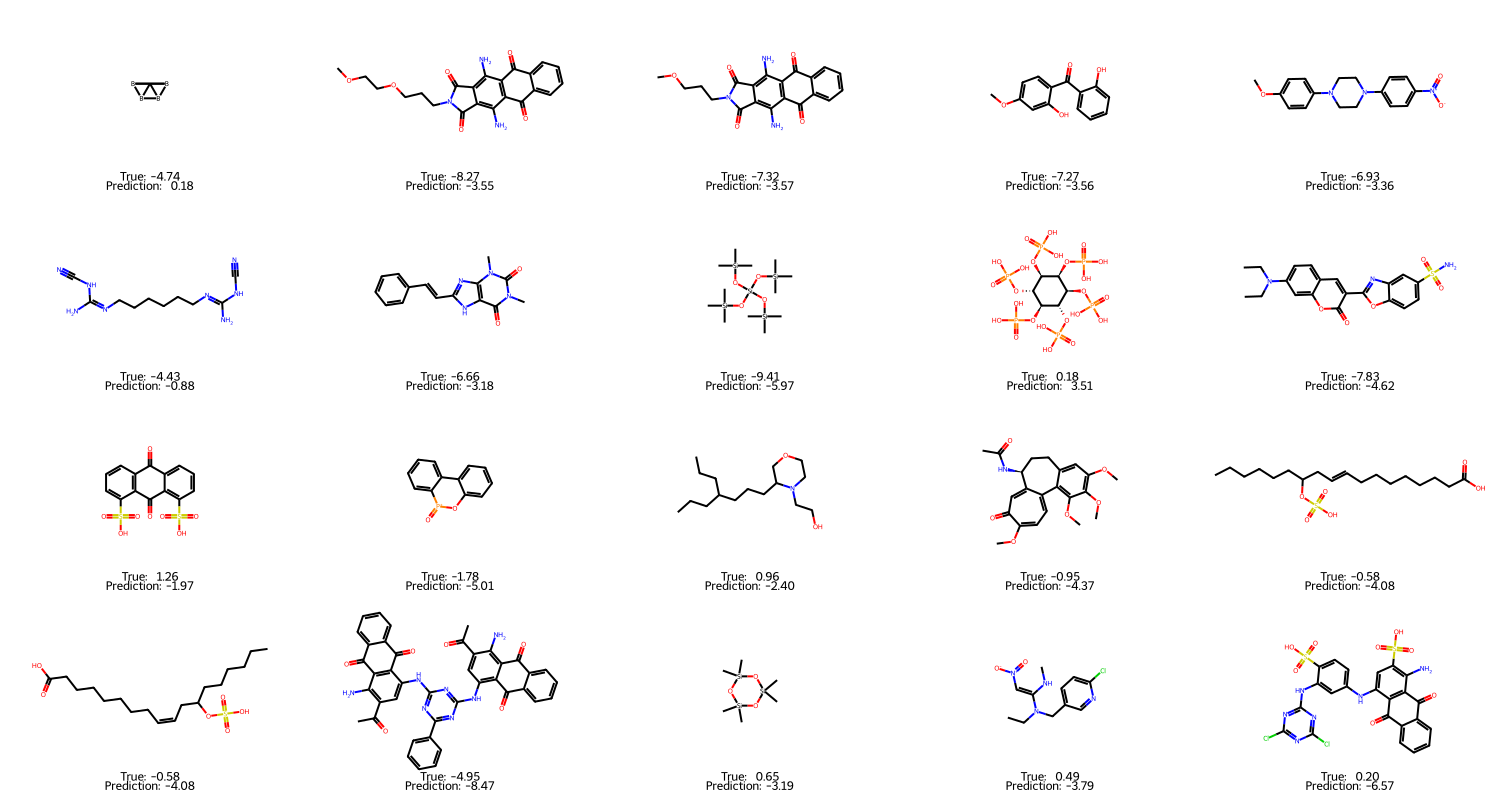

In [33]:
# Convert SMILES strings to molecule objects
molecules = []
legends = []
for index, row in top10_underestimated.iterrows():
    mol = MolFromSmiles(row['SMILES'])
    molecules.append(mol)
    legends.append(f"True: {row["solubility"]: .2f}\nPrediction: {row["prediction"]: .2f}")
    
for index, row in top10_overestimated.iterrows():
    mol = MolFromSmiles(row['SMILES'])
    molecules.append(mol)
    legends.append(f"True: {row["solubility"]: .2f}\nPrediction: {row["prediction"]: .2f}")

Draw.MolsToGridImage(molecules, molsPerRow=5, legends=legends, subImgSize=(300,200))